In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None) 
plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
data = pd.read_csv("new_train.csv")

In [3]:
# Removing features to reduce dimensionality for knn model
train = data.drop(['vendor_id','passenger_count', 'fwd_Y', 'fwd_N', 'pickup_cluster','dropoff_cluster','trip_duration', 'log_trip_duration', 'maximum temerature', 'minimum temperature', 'average temperature', 'precipitation', 'snow fall', 'snow depth'],axis=1)
train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,distance
0,-73.982155,40.767937,-73.964630,40.765602,3,0,17,14,6369878.0,1.502172
1,-73.975090,40.758766,-73.953201,40.765068,3,0,14,14,6357922.0,1.976279
2,-73.994484,40.745087,-73.998993,40.722710,3,0,15,14,6361461.0,2.513961
3,-73.944359,40.714489,-73.910530,40.709492,3,0,4,14,6323059.0,2.911908
4,-73.952881,40.766468,-73.978630,40.761921,3,0,14,14,6361059.0,2.231986


In [4]:
#Performing feature scaling

scaler = RobustScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns = train.columns)

In [5]:
train_scaled.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_month,pickup_dayofweek,pickup_hour,pickup_day,pickup_second,distance
0,-0.015654,0.448058,0.547750,0.333524,-0.333333,-0.75,0.3,-0.066667,-0.205136,-0.222708
1,0.274264,0.150754,0.958836,0.317468,-0.333333,-0.75,0.0,-0.066667,-0.206718,-0.036223
2,-0.521603,-0.292728,-0.688255,-0.956073,-0.333333,-0.75,0.1,-0.066667,-0.206250,0.175270
3,1.535379,-1.284690,2.493688,-1.353481,-0.333333,-0.75,-1.0,-0.066667,-0.211332,0.331798
4,1.185661,0.400445,0.044182,0.222847,-0.333333,-0.75,0.0,-0.066667,-0.206303,0.064358


In [6]:
def rmsle(real, predicted): #calculating Rmsle
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train_scaled, data['log_trip_duration'], test_size=0.2, random_state=43)

In [8]:
knn_model = KNeighborsRegressor(n_neighbors=10,weights='distance') #training KNN model
knn_model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

In [9]:
pred = knn_model.predict(X_valid) #Prediction

In [10]:
pred = np.abs(pred) #calculating cv scores

print("Rmsle = ",rmsle(np.exp(y_valid.values), np.exp(pred)))
print("Rmse = ",np.sqrt(mean_squared_error(np.exp(y_valid),np.exp(pred))))
print("r2_score = ",r2_score(np.exp(y_valid), np.exp(pred)))

Rmsle =  0.391675460232
Rmse =  315.133671756
r2_score =  0.764594641677


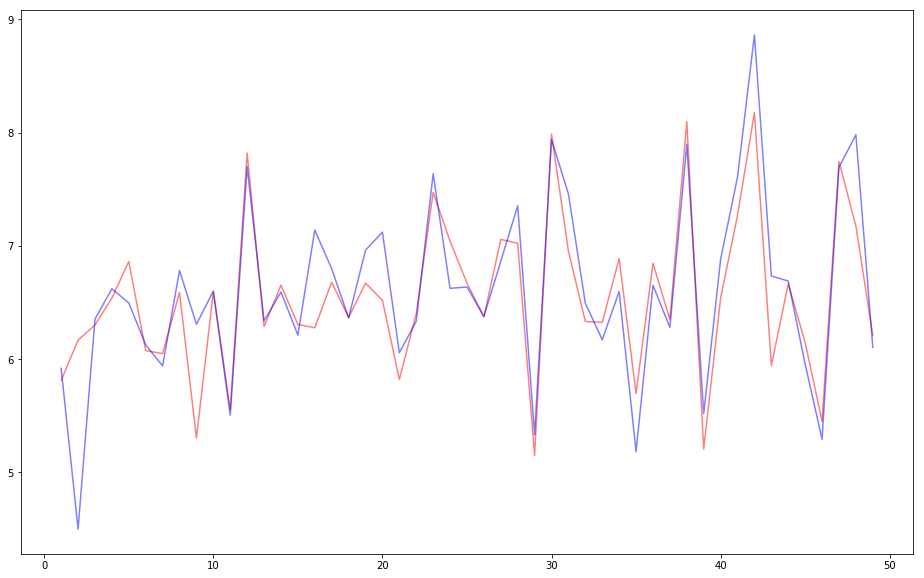

In [11]:
a = 1           #Visualising difference in predicted and actual values
b = 50
plt.plot(range(a, b),pred[a:b], c = 'r' , alpha=0.5)
plt.plot(range(a, b), y_valid[a:b], c = 'b', alpha = 0.5)
plt.show()

In [12]:
testd  = pd.read_csv("new_test.csv") #loading Kaggle test data
ids = testd['id']
test_scaled = scaler.transform(testd.drop(['id','vendor_id','passenger_count', 'fwd_Y', 'fwd_N', 'pickup_cluster','dropoff_cluster','maximum temerature', 'minimum temperature', 'average temperature', 'precipitation', 'snow fall', 'snow depth'], axis=1))

In [13]:
predt = knn_model.predict(test_scaled)

In [15]:
submission = pd.DataFrame({'id': ids, 'trip_duration': np.exp(predt)})  #Writing predictions on kaggle test data to file
submission.to_csv('knnfinal.csv', index=False)